In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
diagnoses_df = pd.read_csv('cleaned_D_ICD_DIAGNOSES.csv')
patients_df = pd.read_csv('cleaned_PATIENTS.csv')
prescriptions_df = pd.read_csv('cleaned_PRESCRIPTIONS.csv')

/var/folders/kw/fxbbvv5x7lvct1l7rdc18tkw0000gn/T/ipykernel_10566/3639269906.py:3: DtypeWarning: Columns (11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions_df = pd.read_csv('cleaned_PRESCRIPTIONS.csv')


In [3]:
diagnoses_df.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,tb pneumonia-oth test,"tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,tb pneumothorax-unspec,"tuberculous pneumothorax, unspecified"
2,176,01171,tb pneumothorax-no exam,"tuberculous pneumothorax, bacteriological or h..."
3,177,01172,tb pneumothorx-exam unkn,"tuberculous pneumothorax, bacteriological or h..."
4,178,01173,tb pneumothorax-micro dx,"tuberculous pneumothorax, tubercle bacilli fou..."


In [4]:
patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaN,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaN,NaN,NaN,0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0


In [5]:
prescriptions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11,2175-06-12,MAIN,tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2.0,mg,2,CAP,po
1,2214775,6,107064,NaN,2175-06-11,2175-06-12,MAIN,warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5.0,mg,1,TAB,po
2,2216265,6,107064,NaN,2175-06-11,2175-06-12,BASE,d5w,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250.0,ml,250,ml,iv
3,2214773,6,107064,NaN,2175-06-11,2175-06-12,MAIN,furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20.0,mg,1,TAB,po
4,2214774,6,107064,NaN,2175-06-11,2175-06-15,MAIN,warfarin,Warfarin,Warfarin,WARF0,014198,56016975.0,Check with MD for Dose,1.0,dose,1,dose,po


In [6]:
prescriptions_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTDATE', 'ENDDATE',
       'DRUG_TYPE', 'DRUG', 'DRUG_NAME_POE', 'DRUG_NAME_GENERIC',
       'FORMULARY_DRUG_CD', 'GSN', 'NDC', 'PROD_STRENGTH', 'DOSE_VAL_RX',
       'DOSE_UNIT_RX', 'FORM_VAL_DISP', 'FORM_UNIT_DISP', 'ROUTE'],
      dtype='object')

In [16]:
prescriptions_df["DRUG"].nunique()

3798

In [22]:
prescriptions_df["DRUG_TYPE"].describe()

count     3859168
unique          3
top          MAIN
freq      2930412
Name: DRUG_TYPE, dtype: object

In [18]:
prescriptions_df["DRUG_NAME_GENERIC"].nunique()

2832

In [19]:
prescriptions_df["DRUG_NAME_POE"].nunique()


3916

In [20]:
prescriptions_df["FORMULARY_DRUG_CD"].nunique()


3241

In [32]:
prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE'])
prescriptions_df['ENDDATE'] = pd.to_datetime(prescriptions_df['ENDDATE'])
prescriptions_df['DURATION'] = (prescriptions_df['ENDDATE'] - prescriptions_df['STARTDATE']).dt.days

# Merge datasets
merged_df = pd.merge(patients_df[['SUBJECT_ID', 'EXPIRE_FLAG']], prescriptions_df[['SUBJECT_ID', 'DRUG_NAME_GENERIC', 'DRUG_TYPE', 'DRUG', 'DURATION']], on='SUBJECT_ID')

In [33]:
merged_df.isna().sum()

SUBJECT_ID                 0
EXPIRE_FLAG                0
DRUG_NAME_GENERIC    1595328
DRUG_TYPE                  0
DRUG                       0
DURATION                   0
dtype: int64

In [34]:
merged_df.dropna(inplace=True)
merged_df.shape

(2263840, 6)

In [35]:
merged_df.to_csv('./drug_expire.csv', index=False)

In [9]:
# sns.scatterplot(data=merged_df, x='DURATION', y='EXPIRE_FLAG')
# plt.xlabel('Duration of Prescription (Days)')
# plt.ylabel('Mortality Flag (1 for deceased)')
# plt.title('Correlation between Prescription Duration and Mortality')
# plt.show()

In [10]:
# sns.boxplot(x='EXPIRE_FLAG', y='DURATION', data=merged_df)
# plt.xlabel('Mortality Flag (1 for deceased)')
# plt.ylabel('Duration of Prescription (Days)')
# plt.title('Prescription Duration by Mortality Outcome')
# plt.show()

In [15]:
merged_df.describe()

,SUBJECT_ID,EXPIRE_FLAG,DURATION
count,3.859168e+06,3.859168e+06,3.859168e+06
mean,3.866422e+04,4.649264e-01,2.837399e+00
std,2.924558e+04,4.987684e-01,1.889568e+01
min,2.000000e+00,0.000000e+00,0.000000e+00
25%,1.449200e+04,0.000000e+00,1.000000e+00
50%,2.848800e+04,0.000000e+00,1.000000e+00
75%,6.305300e+04,1.000000e+00,3.000000e+00
max,9.999900e+04,1.000000e+00,3.506900e+04


In [12]:
# survived = merged_df[merged_df['EXPIRE_FLAG'] == 0]['DURATION']
# deceased = merged_df[merged_df['EXPIRE_FLAG'] == 1]['DURATION']
# 
# sns.kdeplot(survived, label='Survived', shade=True)
# sns.kdeplot(deceased, label='Deceased', shade=True)
# plt.xlabel('Duration of Prescription (Days)')
# plt.ylabel('Density')
# plt.title('Density Plot of Prescription Duration by Mortality Outcome')
# plt.legend()
# plt.show()

In [13]:
# # Convert 'DRUG' column to categorical and get dummy variables
# drug_dummies = pd.get_dummies(merged_df['DRUG'])
# merged_with_dummies_df = pd.concat([merged_df, drug_dummies], axis=1)
# 
# # Ensure that we only include numeric columns for the correlation matrix
# numeric_columns = merged_with_dummies_df.select_dtypes(include=['number']).drop(["SUBJECT_ID"], axis=1)
# 
# # Calculate the correlation matrix
# correlation_matrix = numeric_columns.corr()
# 
# # Plot the heatmap
# sns.heatmap(correlation_matrix, annot=False)  # annot=True can be overwhelming with many variables
# plt.title('Heatmap of Drug Types and Mortality Correlation')
# plt.show()

In [37]:
drug_expire = pd.read_csv('drug_expire.csv')

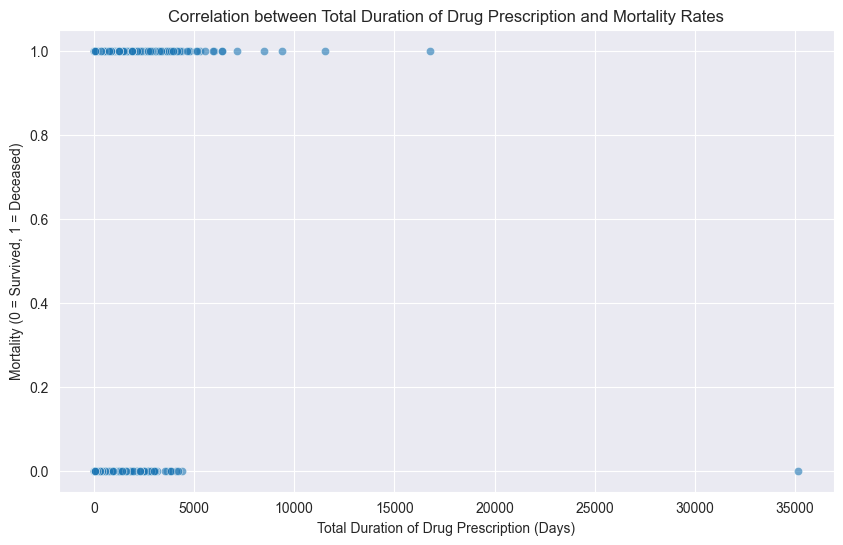

0.12559004282177236

In [38]:
# Aggregate the total duration of drug prescriptions per patient
patient_duration = drug_expire.groupby('SUBJECT_ID')['DURATION'].sum().reset_index()

# Merge this with the mortality flag to get a dataframe suitable for correlation analysis
mortality_duration = patient_duration.merge(drug_expire[['SUBJECT_ID', 'EXPIRE_FLAG']].drop_duplicates(), on='SUBJECT_ID')

# Scatter plot for correlation between the total duration of drug prescription and mortality rates
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mortality_duration, x='DURATION', y='EXPIRE_FLAG', alpha=0.6)
plt.title('Correlation between Total Duration of Drug Prescription and Mortality Rates')
plt.xlabel('Total Duration of Drug Prescription (Days)')
plt.ylabel('Mortality (0 = Survived, 1 = Deceased)')
plt.grid(True)
plt.show()

# Calculate the correlation coefficient for duration and expire flag
correlation_coef = mortality_duration['DURATION'].corr(mortality_duration['EXPIRE_FLAG'])
correlation_coef

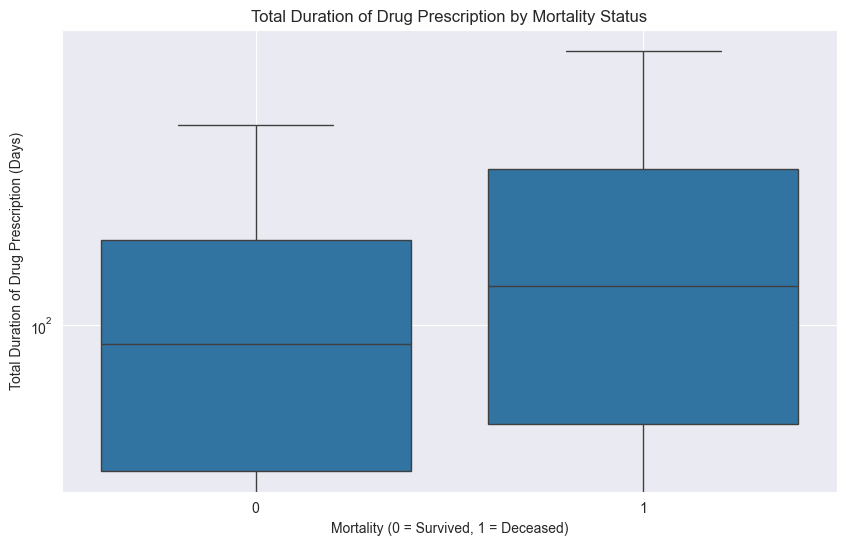

In [49]:
# Aggregate the total duration of drug prescriptions per patient
patient_duration = drug_expire.groupby('SUBJECT_ID')['DURATION'].sum().reset_index()

# Merge this with the mortality flag to get a dataframe suitable for correlation analysis
mortality_duration = patient_duration.merge(drug_expire[['SUBJECT_ID', 'EXPIRE_FLAG']].drop_duplicates(), on='SUBJECT_ID')

# Create a boxplot with log scale
plt.figure(figsize=(10, 6))
sns.boxplot(data=mortality_duration, x='EXPIRE_FLAG', y='DURATION', showfliers=False)
plt.yscale('log')  # Set y-axis to log scale
plt.title('Total Duration of Drug Prescription by Mortality Status')
plt.xlabel('Mortality (0 = Survived, 1 = Deceased)')
plt.ylabel('Total Duration of Drug Prescription (Days)')
plt.grid(True)
plt.show()

In [58]:
# The goal is to have each entry include patient ID, drug information, total duration of that particular drug, and the number of times this drug prescribed to this patient.

# Grouping the data by 'SUBJECT_ID' and 'DRUG_NAME_GENERIC' to aggregate the total duration and count the prescriptions
drug_patient_summary = drug_expire.groupby(['SUBJECT_ID', 'DRUG_NAME_GENERIC']).agg(
    Total_Duration=('DURATION', 'sum'),
    Prescription_Count=('DRUG_NAME_GENERIC', 'count')
).reset_index()

# Merging the summary data back with the original to include 'EXPIRE_FLAG'
drug_patient_complete = pd.merge(
    drug_patient_summary,
    drug_expire[['SUBJECT_ID', 'DRUG_NAME_GENERIC', 'EXPIRE_FLAG']].drop_duplicates(),
    on=['SUBJECT_ID', 'DRUG_NAME_GENERIC'],
    how='left'
)

# Now, proceed with the analysis similar to before, focusing on the top drugs but considering the newly structured data
# Selecting the top 10 most frequently prescribed drugs
top_drugs = drug_patient_complete['DRUG_NAME_GENERIC'].value_counts().head(10).index.tolist()

# Filter the dataset to include only the top drugs
top_drugs_df = drug_patient_complete[drug_patient_complete['DRUG_NAME_GENERIC'].isin(top_drugs)]

# Aggregate data by drug and mortality flag, summing the total duration and counting the number of prescriptions
drug_mortality_summary = top_drugs_df.groupby(['DRUG_NAME_GENERIC', 'EXPIRE_FLAG']).agg(
    Total_Duration=('Total_Duration', 'sum'),
    Prescription_Count=('Prescription_Count', 'sum')
).unstack(fill_value=0)

# Calculate the mortality rate as before
drug_mortality_summary['Mortality Rate'] = drug_mortality_summary[('Prescription_Count', 1)] / (
    drug_mortality_summary[('Prescription_Count', 0)] + drug_mortality_summary[('Prescription_Count', 1)]
)

In [64]:
drug_mortality_summary.columns

MultiIndex([(    'Total_Duration',  0),
            (    'Total_Duration',  1),
            ('Prescription_Count',  0),
            ('Prescription_Count',  1),
            (    'Mortality Rate', '')],
           names=[None, 'EXPIRE_FLAG'])

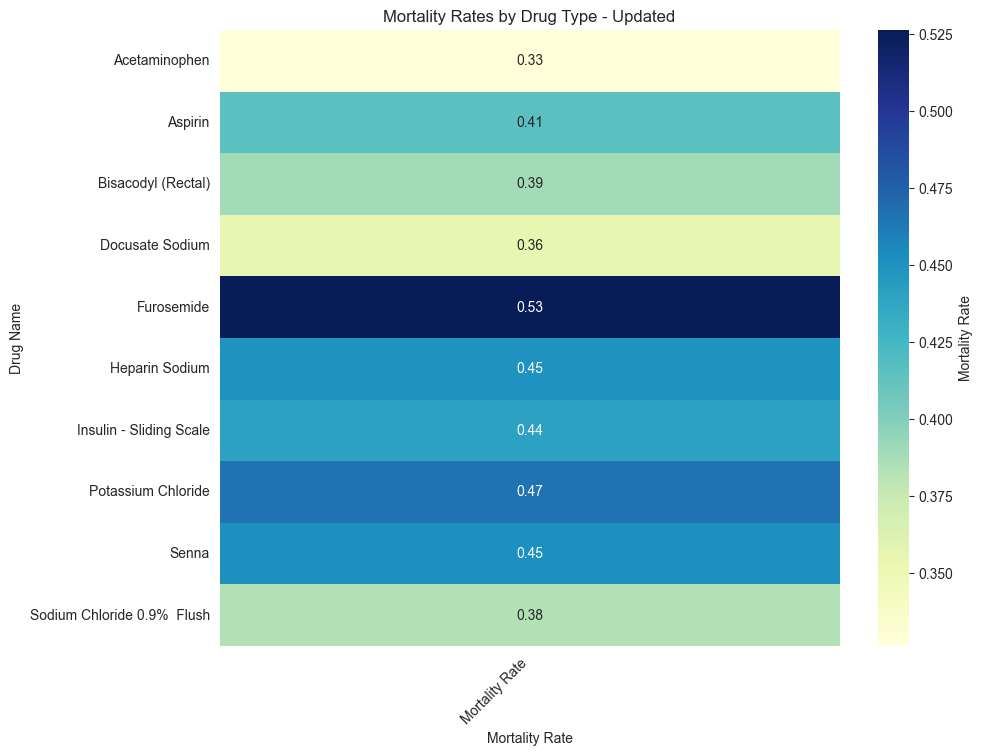

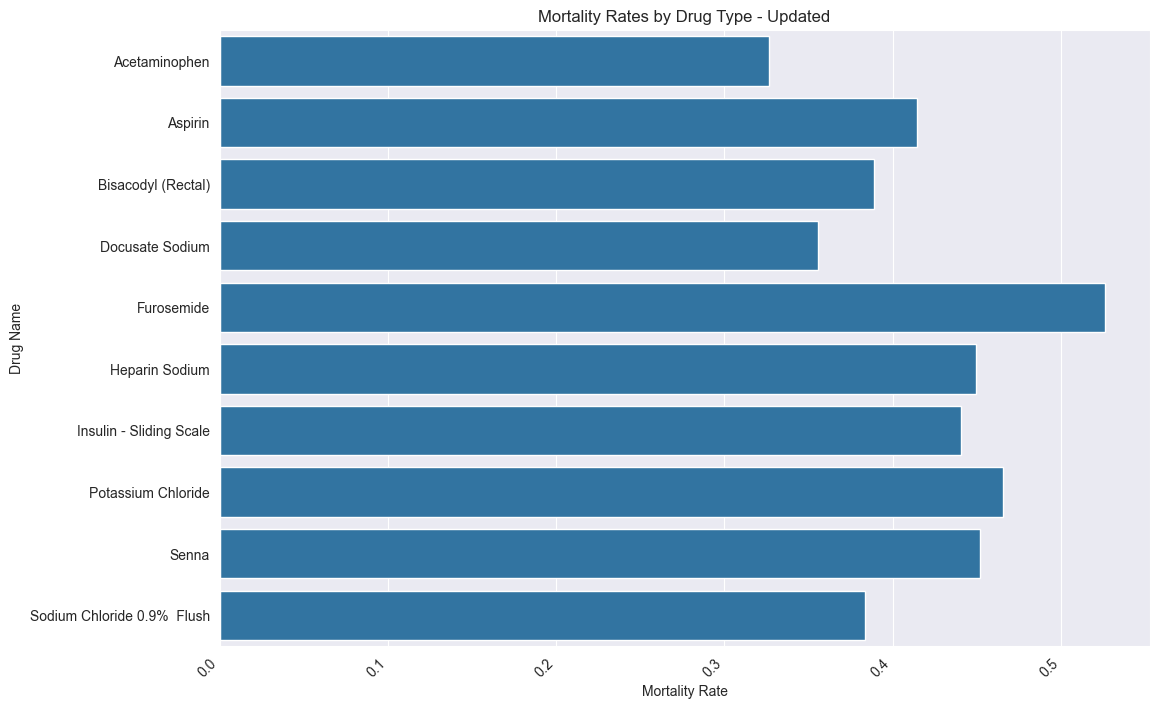

In [63]:

# Preparing data for the visualizations
heatmap_data = drug_mortality_summary[['Mortality Rate']].reset_index()
heatmap_data.columns = ['DRUG_NAME_GENERIC', 'Mortality Rate']
heatmap_data.set_index('DRUG_NAME_GENERIC', inplace=True)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data=heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'}, fmt=".2f")
plt.title('Mortality Rates by Drug Type - Updated')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plotting the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Mortality Rate', y='DRUG_NAME_GENERIC', data=heatmap_data.reset_index())
plt.title('Mortality Rates by Drug Type - Updated')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

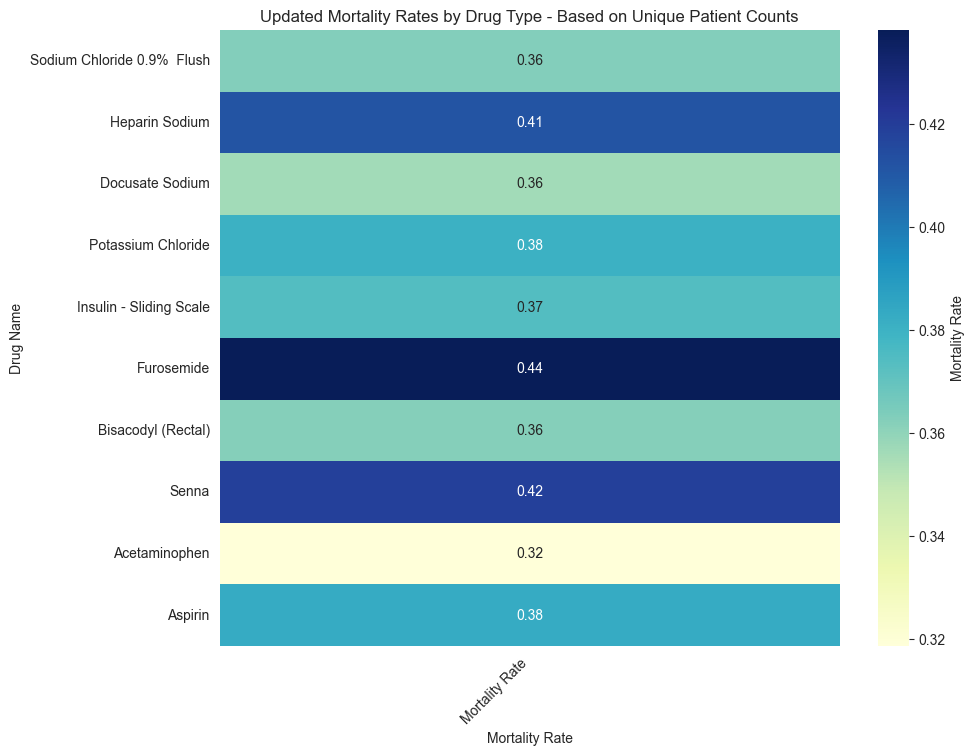

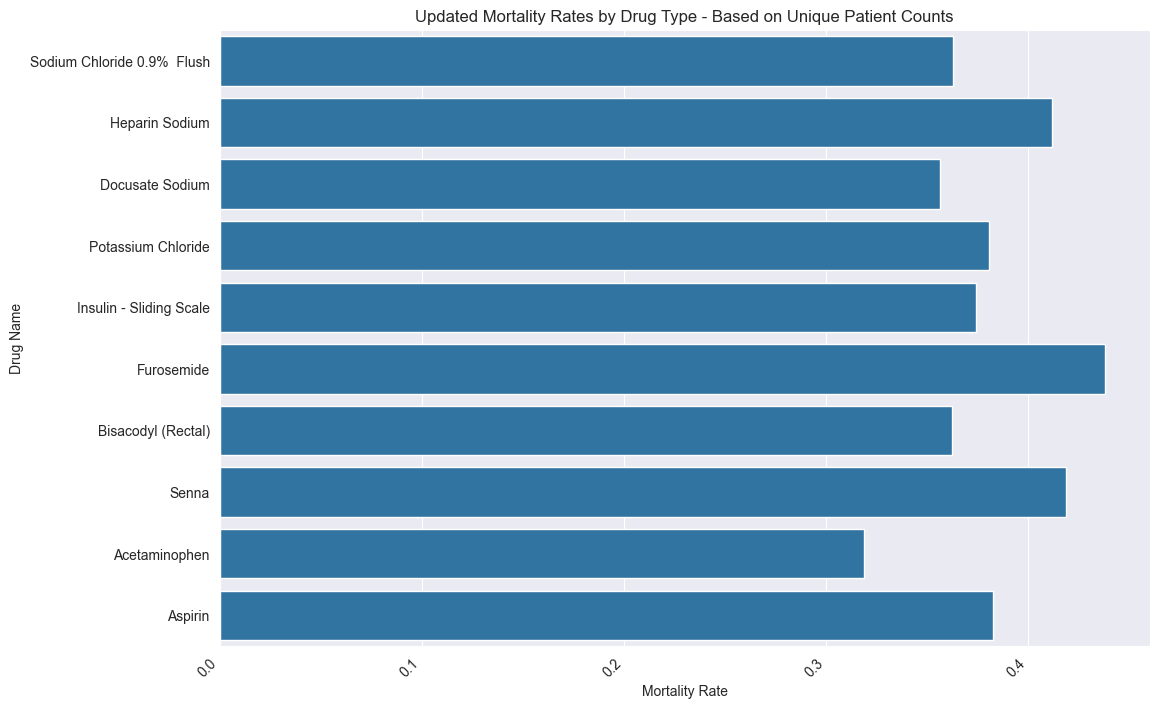

In [69]:
# It seems there was an issue with the previous execution. Let's attempt the operation again, ensuring correctness.

# Adjusting to calculate mortality rate based on unique patient counts for each drug

# First, calculating unique patients per drug and their expiration status
unique_patient_drug_expire = drug_patient_complete.groupby(['DRUG_NAME_GENERIC', 'EXPIRE_FLAG'])['SUBJECT_ID'].nunique().unstack(fill_value=0)

# Calculate the new mortality rate based on unique patient counts
unique_patient_drug_expire['Mortality Rate'] = unique_patient_drug_expire[1] / (unique_patient_drug_expire[0] + unique_patient_drug_expire[1])

# Preparing the visualization data, focusing on the top drugs
new_heatmap_data = unique_patient_drug_expire.loc[top_drugs, ['Mortality Rate']]

# Plotting the heatmap for the updated mortality rates
plt.figure(figsize=(10, 8))
sns.heatmap(data=new_heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'}, fmt=".2f")
plt.title('Updated Mortality Rates by Drug Type - Based on Unique Patient Counts')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plotting the bar chart for the updated mortality rates
plt.figure(figsize=(12, 8))
sns.barplot(x='Mortality Rate', y=new_heatmap_data.reset_index()['DRUG_NAME_GENERIC'], data=new_heatmap_data.reset_index())
plt.title('Updated Mortality Rates by Drug Type - Based on Unique Patient Counts')
plt.xlabel('Mortality Rate')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

In [65]:
heatmap_data.head()

,Mortality Rate
DRUG_NAME_GENERIC,
Acetaminophen,0.326341
Aspirin,0.414776
Bisacodyl (Rectal),0.389021
Docusate Sodium,0.355898
Furosemide,0.526440


In [66]:
drug_patient_complete

,SUBJECT_ID,DRUG_NAME_GENERIC,Total_Duration,Prescription_Count,EXPIRE_FLAG
0,4,Acyclovir,7,1,0
1,4,Benzonatate,0,1,0
2,4,Clindamycin HCl,1,1,0
3,4,Clonazepam,11,4,0
4,4,Didanosine,5,1,0
...,...,...,...,...,...
1037657,99999,Milk Of Magnesia,4,1,0
1037658,99999,Nortriptyline HCl,5,1,0
1037659,99999,Racepinephrine,0,1,0
1037660,99999,Senna,4,2,0


In [67]:
drug_mortality_summary[('Prescription_Count', 1)] 

DRUG_NAME_GENERIC
Acetaminophen                  11139
Aspirin                        10970
Bisacodyl (Rectal)              9992
Docusate Sodium                15194
Furosemide                     64720
Heparin Sodium                 21548
Insulin - Sliding Scale        30139
Potassium Chloride             40187
Senna                          13121
Sodium Chloride 0.9%  Flush    31972
Name: (Prescription_Count, 1), dtype: int64

In [55]:
# Selecting the top 10 most frequently prescribed drugs
top_drugs = drug_expire['DRUG_NAME_GENERIC'].value_counts().head(10).index.tolist()

# Filter the dataset to include only the top drugs
top_drugs_df = drug_expire[drug_expire['DRUG_NAME_GENERIC'].isin(top_drugs)]

# Preparing data for the heatmap
# We need to calculate the mortality rate for each drug
# First, aggregate data by drug and mortality flag, counting the number of prescriptions
drug_mortality = top_drugs_df.groupby(['DRUG_NAME_GENERIC', 'EXPIRE_FLAG']).size().unstack(fill_value=0)

# Calculate the mortality rate as the number of deceased patients (1) divided by the total number of prescriptions per drug
drug_mortality['Mortality Rate'] = drug_mortality[1] / (drug_mortality[0] + drug_mortality[1])

# Select only the mortality rate for the heatmap
heatmap_data = drug_mortality[['Mortality Rate']].reset_index()

# Pivot the data for the heatmap
heatmap_pivot = heatmap_data.pivot("DRUG_NAME_GENERIC", "DRUG_NAME_GENERIC", "Mortality Rate")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=heatmap_pivot, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'})
plt.title('Mortality Rates by Drug Type')
plt.xlabel('Drug Name')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()


TypeError: pivot() takes 1 positional argument but 4 were given

In [56]:
# Selecting the top 10 most frequently prescribed drugs
top_drugs = drug_expire['DRUG_NAME_GENERIC'].value_counts().head(10).index.tolist()

# Filter the dataset to include only the top drugs
top_drugs_df = drug_expire[drug_expire['DRUG_NAME_GENERIC'].isin(top_drugs)]

# Preparing data for the heatmap
# We need to calculate the mortality rate for each drug
# First, aggregate data by drug and mortality flag, counting the number of prescriptions
drug_mortality = top_drugs_df.groupby(['DRUG_NAME_GENERIC', 'EXPIRE_FLAG']).size().unstack(fill_value=0)

# Calculate the mortality rate as the number of deceased patients (1) divided by the total number of prescriptions per drug
drug_mortality['Mortality Rate'] = drug_mortality[1] / (drug_mortality[0] + drug_mortality[1])

# Select only the mortality rate for the heatmap
heatmap_data = drug_mortality[['Mortality Rate']].reset_index()

# Pivot the data for the heatmap
heatmap_pivot = heatmap_data.pivot(index=0, columns='DRUG_NAME_GENERIC', values='Mortality Rate')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=heatmap_pivot, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mortality Rate'})
plt.title('Mortality Rates by Drug Type')
plt.xlabel('Drug Name')
plt.ylabel('Drug Name')
plt.xticks(rotation=45, ha='right')
plt.show()

KeyError: 0

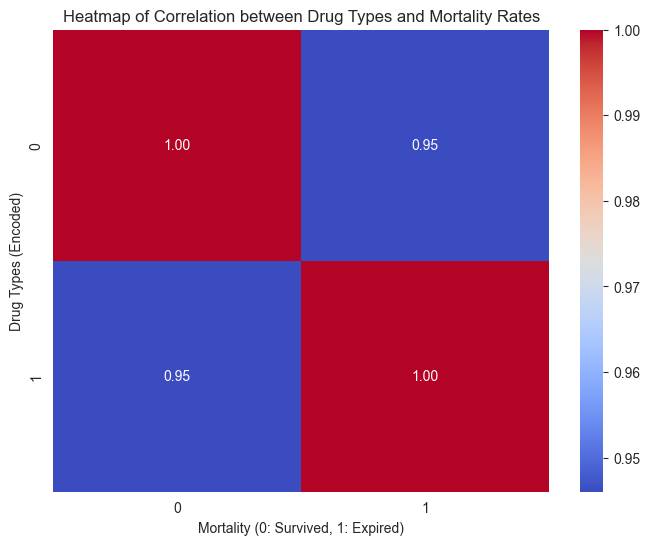

In [48]:
from sklearn.preprocessing import LabelEncoder
drug_expire2 = pd.read_csv('drug_expire.csv')

# Encoding drug names to numerical values for the heatmap
encoder = LabelEncoder()
drug_expire2['DRUG_ENCODED'] = encoder.fit_transform(drug_expire2['DRUG_NAME_GENERIC'])

# Creating a pivot table for the heatmap
heatmap_data = drug_expire2.pivot_table(values='DURATION', index='DRUG_ENCODED', columns='EXPIRE_FLAG', aggfunc='count', fill_value=0)

# Calculating correlation for the heatmap
corr = heatmap_data.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation between Drug Types and Mortality Rates')
plt.xlabel('Mortality (0: Survived, 1: Expired)')
plt.ylabel('Drug Types (Encoded)')
plt.show()
